# HW6, DATSCI W261

Team: Kuan Lin, Alejandro J. Rojas, Ricardo Barrera<br/>
Emails: kuanlin@ischool.berkeley.edu, ale@ischool.berkeley.edu, ricardofrank@ischool.berkeley.edu<br/>
Time of Initial Submission: 8:00 AM PST, Thursday, March 19, 2016<br/>
W261-1, Spring 2016 Week 9 Homework

# HW 9.0: Short answer questions

What is PageRank and what is it used for in the context of web search?
What modifications have to be made to the webgraph in order to leverage the machinery of Markov Chains to 
compute the steady stade distibuton?<br/>
OPTIONAL: In topic-specific pagerank, how can we insure that the irreducible property is satified? (HINT: see HW9.4)

#### Answer:

PageRank is a way to rank importance of nodes in a network.  By modeling the transition within a network as a Markov process, PageRank can be derived by finding the left eigenvector of the transition matrix, which can be interpreted as the steady-state probability of each node.  Nodes with higher steady-state probability is therefore ranked higher.  In the context of web search, the 'transition' can be interpreted as a person surfing among many webpages, and the resulting steady-state probability is the probability of the surfer visiting a specific page.  In addition, the algorithm needs the following modifications before applying to webgraphs:

- Redistribution of weights from dangling nodes (nodes with no outlinks).  This is to ensure total probabilities sum up to one.
- Teleportation: This is a small probability that a user would randomly jump to another webpage rather than via following a link.
- For topic-specific PageRank, we can ensure graph irreducibility by removing nodes unreachable within each topic

# HW 9.1: MRJob implementation of basic PageRank

Write a basic MRJob implementation of the iterative PageRank algorithm
that takes sparse adjacency lists as input (as explored in HW 7).
Make sure that you implementation utilizes teleportation (1-damping/the number of nodes in the network), 
and further, distributes the mass of dangling nodes with each iteration
so that the output of each iteration is correctly normalized (sums to 1).
[NOTE: The PageRank algorithm assumes that a random surfer (walker), starting from a random web page,
chooses the next page to which it will move by clicking at random, with probability d,
one of the hyperlinks in the current page. This probability is represented by a so-called
‘damping factor’ d, where d ∈ (0, 1). Otherwise, with probability (1 − d), the surfer
jumps to any web page in the network. If a page is a dangling end, meaning it has no
outgoing hyperlinks, the random surfer selects an arbitrary web page from a uniform
distribution and “teleports” to that page]


As you build your code, use the test data

s3://ucb-mids-mls-networks/PageRank-test.txt
Or under the Data Subfolder for HW7 on Dropbox with the same file name. 
(On Dropbox https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0)

with teleportation parameter set to 0.15 (1-d, where d, the damping factor is set to 0.85), and crosscheck
your work with the true result, displayed in the first image
in the Wikipedia article:

https://en.wikipedia.org/wiki/PageRank

and here for reference are the corresponding PageRank probabilities:

<pre>
A,0.033
B,0.384
C,0.343
D,0.039
E,0.081
F,0.039
G,0.016
H,0.016
I,0.016
J,0.016
K,0.016
</pre>

In [15]:
%%writefile pageRank.py
from mrjob.job import MRJob
from mrjob.step import MRStep
#from mrjob.protocol import ReprProtocol
#from mrjob.protocol import RawProtocol

class PageRank(MRJob):
    
    #OUTPUT_PROTOCOL = ReprProtocol
    
    def configure_options(self):
        super(PageRank, self).configure_options()

        self.add_passthrough_option(
            '--prob-norm-factor', dest='prob_norm_factor', default=0.0, type='float',
            help='normalization factor for node weights')

        self.add_passthrough_option(
            '--damping-factor', dest='damping_factor', default=0.85,
            type='float',
            help='probability a web surfer will continue clicking on links')
        
        self.add_passthrough_option(
            '--total-nodes', dest='total_nodes', default=-1,
            type='int',
            help='total number of nodes in the graph')
        
        self.add_passthrough_option(
            '--loss-mass', dest='loss_mass', default=0.0,
            type='float',
            help='loss mass that needs to be redistributed')
        
        self.add_passthrough_option(
            '--counter-precision', dest='counter_precision', default=6,
            type='int',
            help='number of decimal points to preserve when using counter to store floats')
        
        self.add_passthrough_option(
            '--prank-chg-thold', dest='prank_chg_thold', default=0.001,
            type='float',
            help='threshold for change in PageRank value to continue iteration')
        
        self.add_passthrough_option(
            '--is-final-iter', dest='is_final_iter', default=0,
            type='int',
            help='1 indicates final iteration which needs to apply just the mapper.')
    
    def sendScores(self, _, line):
        # Mapper, send score to each outline
        
        if self.options.total_nodes == -1:
            # accoumate total node numbers
            self.increment_counter('prank', 'total_nodes', 1)
        
        lineArr = line.strip().split('\t')
        
        if '[' not in line: # original input
            # first iteration, don't have total node numbers yet.
            # initialize pageRank to 1.0, and will have to normalize later
            node_weight = 1.0
            node_id = lineArr[0]
            outlinks = eval(lineArr[1])
            self.increment_counter('prank', 'prod_norm_factor', 1)
        else:
            node_id = lineArr[0].replace('"', '')
            payload = eval(lineArr[1])
            outlinks = payload[0]
            node_weight = payload[1]
            if self.options.prob_norm_factor > 0: # need to re-normalize weights so they sum up to 1
                node_weight = node_weight / self.options.prob_norm_factor
                
            if self.options.total_nodes != -1:
                # accounts for teleportation and dangling nodes
                node_weight = (1-self.options.damping_factor)*(1.0/self.options.total_nodes) + self.options.damping_factor*(self.options.loss_mass/self.options.total_nodes + node_weight)
        
        if self.options.is_final_iter == 1:
            yield node_id, (outlinks, round(node_weight, 4))
        else:
            yield node_id, ('node', outlinks, node_weight) # original node info
            if len(outlinks) == 0:
                # dangling nodes, increment loss mass counter
                self.increment_counter('prank', 'loss_mass', int(node_weight*(10**self.options.counter_precision)))
            else:
                for out_node in outlinks:
                    yield out_node, ('score', 1.0*node_weight/len(outlinks), self.options.counter_precision) # new score
                    
    def sendScoreCombinder(self, nodeId, payload):
        total_new_score = 0.0
        for data in payload:
            if data[0] == 'node':
                yield nodeId, data
            else:
                total_new_score += data[1]
        if total_new_score > 0:
            yield nodeId, ('score', total_new_score)
                
    def receive_scores(self, nodeId, payload):
        prev_score = 0.0
        outlinks = {}
        total_new_score = 0.0
        
        for data in payload:
            if data[0] == 'node':
                outlinks = data[1]
                prev_score = data[2]
            else:
                total_new_score += data[1]
                      
        if abs(total_new_score-prev_score) > self.options.prank_chg_thold:
            self.increment_counter('prank', 'chg_over_thold', 1)
        
        yield nodeId, (outlinks, round(total_new_score, 6))
        
    def steps(self):
        if self.options.is_final_iter == 1:
            return [MRStep(mapper=self.sendScores)]
        else:
            return [MRStep(mapper=self.sendScores, combiner=self.sendScoreCombinder, reducer=self.receive_scores)]
        

Overwriting pageRank.py


#### Page Rank Driver

In [10]:
%load_ext autoreload
%autoreload 2
from pageRank import PageRank

output_dir = 'C:\\Users\\kuanlin\\Desktop\\Berkeley_MIDS\\courses\\W261_ML_at_Scale\\ww9\\PageRankOutputs\\iter'

# first iteration, collect normalization factors
mr_job = PageRank(args=['PageRank-test.txt', '--no-output', '--output-dir='+output_dir+'1'])
with mr_job.make_runner() as runner: 
    runner.run()
    norm_factor = runner.counters()[0]['prank']['prod_norm_factor']
    
# second iteration, normalize initialization values, and collect total nodes
mr_job = PageRank(args=[output_dir+'1', '--no-output', '--output-dir='+output_dir+'2', '--prob-norm-factor='+str(norm_factor)])
with mr_job.make_runner() as runner: 
    runner.run()
    total_nodes = runner.counters()[0]['prank']['total_nodes']
    loss_mass = 0.0
    if 'prank' in runner.counters()[0] and 'loss_mass' in runner.counters()[0]['prank']:
        loss_mass = 1.0*runner.counters()[0]['prank']['loss_mass']/(10**mr_job.options.counter_precision)

# iter until no changes or max iter reached
iter_num = 2
max_iter = 20
while(1):
    iter_num += 1
    
    if iter_num == max_iter or ('prank' in runner.counters()[0] and 'chg_over_thold' not in runner.counters()[0]['prank']):
        final_iter = True
    else:
        final_iter = False
    
    if not final_iter:
        mr_job = PageRank(args=[output_dir+str(iter_num-1), '--no-output', '--output-dir='+output_dir+str(iter_num), 
                '--total-nodes='+str(total_nodes), '--loss-mass='+str(loss_mass)])
    else:
        mr_job = PageRank(args=[output_dir+str(iter_num-1), '--no-output', '--output-dir='+output_dir+str(iter_num), 
                '--total-nodes='+str(total_nodes), '--loss-mass='+str(loss_mass), '--is-final-iter=1'])
    with mr_job.make_runner() as runner: 
        runner.run()
        loss_mass = 0.0
        if 'prank' in runner.counters()[0] and 'loss_mass' in runner.counters()[0]['prank']:
            loss_mass = 1.0*runner.counters()[0]['prank']['loss_mass']/(10**mr_job.options.counter_precision)
    
    if final_iter:
        break
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
# show the result:
output_file = output_dir + str(iter_num) + '\\part-00000'
for line in open(output_file, 'r'): print line.strip()

"A"	[{}, 0.0328]
"B"	[{"C": 1}, 0.3924]
"C"	[{"B": 1}, 0.3351]
"D"	[{"A": 1, "B": 1}, 0.0391]
"E"	[{"B": 1, "D": 1, "F": 1}, 0.0809]
"F"	[{"B": 1, "E": 1}, 0.0391]
"G"	[{"B": 1, "E": 1}, 0.0162]
"H"	[{"B": 1, "E": 1}, 0.0162]
"I"	[{"B": 1, "E": 1}, 0.0162]
"J"	[{"E": 1}, 0.0162]
"K"	[{"E": 1}, 0.0162]


In [96]:
%%writefile topNPageRanks.py

# MRJob code to grab topN pageRanks

from mrjob.job import MRJob

class topNPageRanks(MRJob):
    
    def configure_options(self):
        super(topNPageRanks, self).configure_options()

        self.add_passthrough_option(
            '--top-n', dest='top_n', default=100, type='int',
            help='select top N page ranks')
    
    def mapper(self, _, line):
        lineArr = line.strip().split('\t')
        nodeId = lineArr[0].replace('"', '')
        rank_val = eval(lineArr[1])[1]
        yield None, (rank_val, nodeId)
        
    def combiner(self, _, ranked_nodes):
        top_n_nodes = []
        for node in ranked_nodes:
            if len(top_n_nodes) < self.options.top_n:
                top_n_nodes.append(node)
                top_n_nodes = sorted(top_n_nodes, reverse=True)
            elif node[0] > top_n_nodes[self.options.top_n-1][0]:
                top_n_nodes.append(node)
                top_n_nodes = sorted(top_n_nodes, reverse=True)[:self.options.top_n]
        for node in top_n_nodes:
            yield None, node
        
    def reducer(self, _, ranked_nodes):
        top_n_nodes = []
        for node in ranked_nodes:
            if len(top_n_nodes) < self.options.top_n:
                top_n_nodes.append(node)
                top_n_nodes = sorted(top_n_nodes, reverse=True)
            elif node[0] > top_n_nodes[self.options.top_n-1][0]:
                top_n_nodes.append(node)
                top_n_nodes = sorted(top_n_nodes, reverse=True)[:self.options.top_n]
        for node in top_n_nodes:
            yield node[1], node[0]

if __name__ == '__main__':
    topNPageRanks.run()

Overwriting topNPageRanks.py


In [98]:
!python topNPageRanks.py C:\\Users\\kuanlin\\Desktop\\Berkeley_MIDS\\courses\\W261_ML_at_Scale\\ww9\\PageRankOutputs\\iter20 --top-n=5

"B"	0.3924
"C"	0.3351
"E"	0.0809
"F"	0.0391
"D"	0.0391


no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating tmp directory c:\temp\topNPageRanks.kuanlin.20160314.070605.221000

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

writing to c:\temp\topNPageRanks.kuanlin.20160314.070605.221000\step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to c:\temp\topNPageRanks.kuanlin.20160314.070605.221000\step-0-mapper-sorted
> sort 'c:\temp\topNPageRanks.kuanlin.20160314.070605.221000\step-0-mapper_part-00000'
writing to c:\temp\topNPageRanks.kuanlin.20160314.070605.221000\step-0-reducer_part-00000
Counters from step 1:
  (no counters found)
Moving c:\temp\topNPageRanks.kuanlin.20160314.070605.221000\step-0-reducer_part-00000 -> c:\temp\topNPageRanks.kuanlin.20160314.07060

# HW 9.2: Exploring PageRank teleportation and network plots

In order to overcome  problems such as disconnected components, the damping factor (a typical value for d is 0.85) can be varied. 
Using the graph in HW1, plot the test graph (using networkx, https://networkx.github.io/) for several values of the damping parameter alpha,
so that each nodes radius is proportional to its PageRank score. In particular you should
do this for the following damping factors: [0,0.25,0.5,0.75, 0.85, 1]. Note your plots should look like the following:

https://en.wikipedia.org/wiki/PageRank#/media/File:PageRanks-Example.svg

In [57]:
# Make whole bunch of PageRank results with varying damping factors

%load_ext autoreload
%autoreload 2
from pageRank import PageRank

damping_factor = 1

output_dir = 'VaryingDampingFactors\\'+str(damping_factor)+'\\iter'

# first iteration, collect normalization factors
mr_job = PageRank(args=['PageRank-test.txt', '--no-output', '--output-dir='+output_dir+'1'])
with mr_job.make_runner() as runner: 
    runner.run()
    norm_factor = runner.counters()[0]['prank']['prod_norm_factor']
    
# second iteration, normalize initialization values, and collect total nodes
mr_job = PageRank(args=[output_dir+'1', '--no-output', '--output-dir='+output_dir+'2', '--prob-norm-factor='+str(norm_factor)])
with mr_job.make_runner() as runner: 
    runner.run()
    total_nodes = runner.counters()[0]['prank']['total_nodes']
    loss_mass = 0.0
    if 'prank' in runner.counters()[0] and 'loss_mass' in runner.counters()[0]['prank']:
        loss_mass = 1.0*runner.counters()[0]['prank']['loss_mass']/(10**mr_job.options.counter_precision)

# iter until no changes or max iter reached
iter_num = 2
max_iter = 20
while(1):
    iter_num += 1
    
    if iter_num == max_iter or ('prank' in runner.counters()[0] and 'chg_over_thold' not in runner.counters()[0]['prank']):
        final_iter = True
    else:
        final_iter = False
    
    if not final_iter:
        mr_job = PageRank(args=[output_dir+str(iter_num-1), '--no-output', '--output-dir='+output_dir+str(iter_num), 
                '--total-nodes='+str(total_nodes), '--loss-mass='+str(loss_mass), '--damping-factor='+str(damping_factor)])
    else:
        mr_job = PageRank(args=[output_dir+str(iter_num-1), '--no-output', '--output-dir='+output_dir+'final', 
                '--total-nodes='+str(total_nodes), '--loss-mass='+str(loss_mass),
                '--damping-factor='+str(damping_factor), '--is-final-iter=1'])
    with mr_job.make_runner() as runner: 
        runner.run()
        loss_mass = 0.0
        if 'prank' in runner.counters()[0] and 'loss_mass' in runner.counters()[0]['prank']:
            loss_mass = 1.0*runner.counters()[0]['prank']['loss_mass']/(10**mr_job.options.counter_precision)
    
    if final_iter:
        break

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


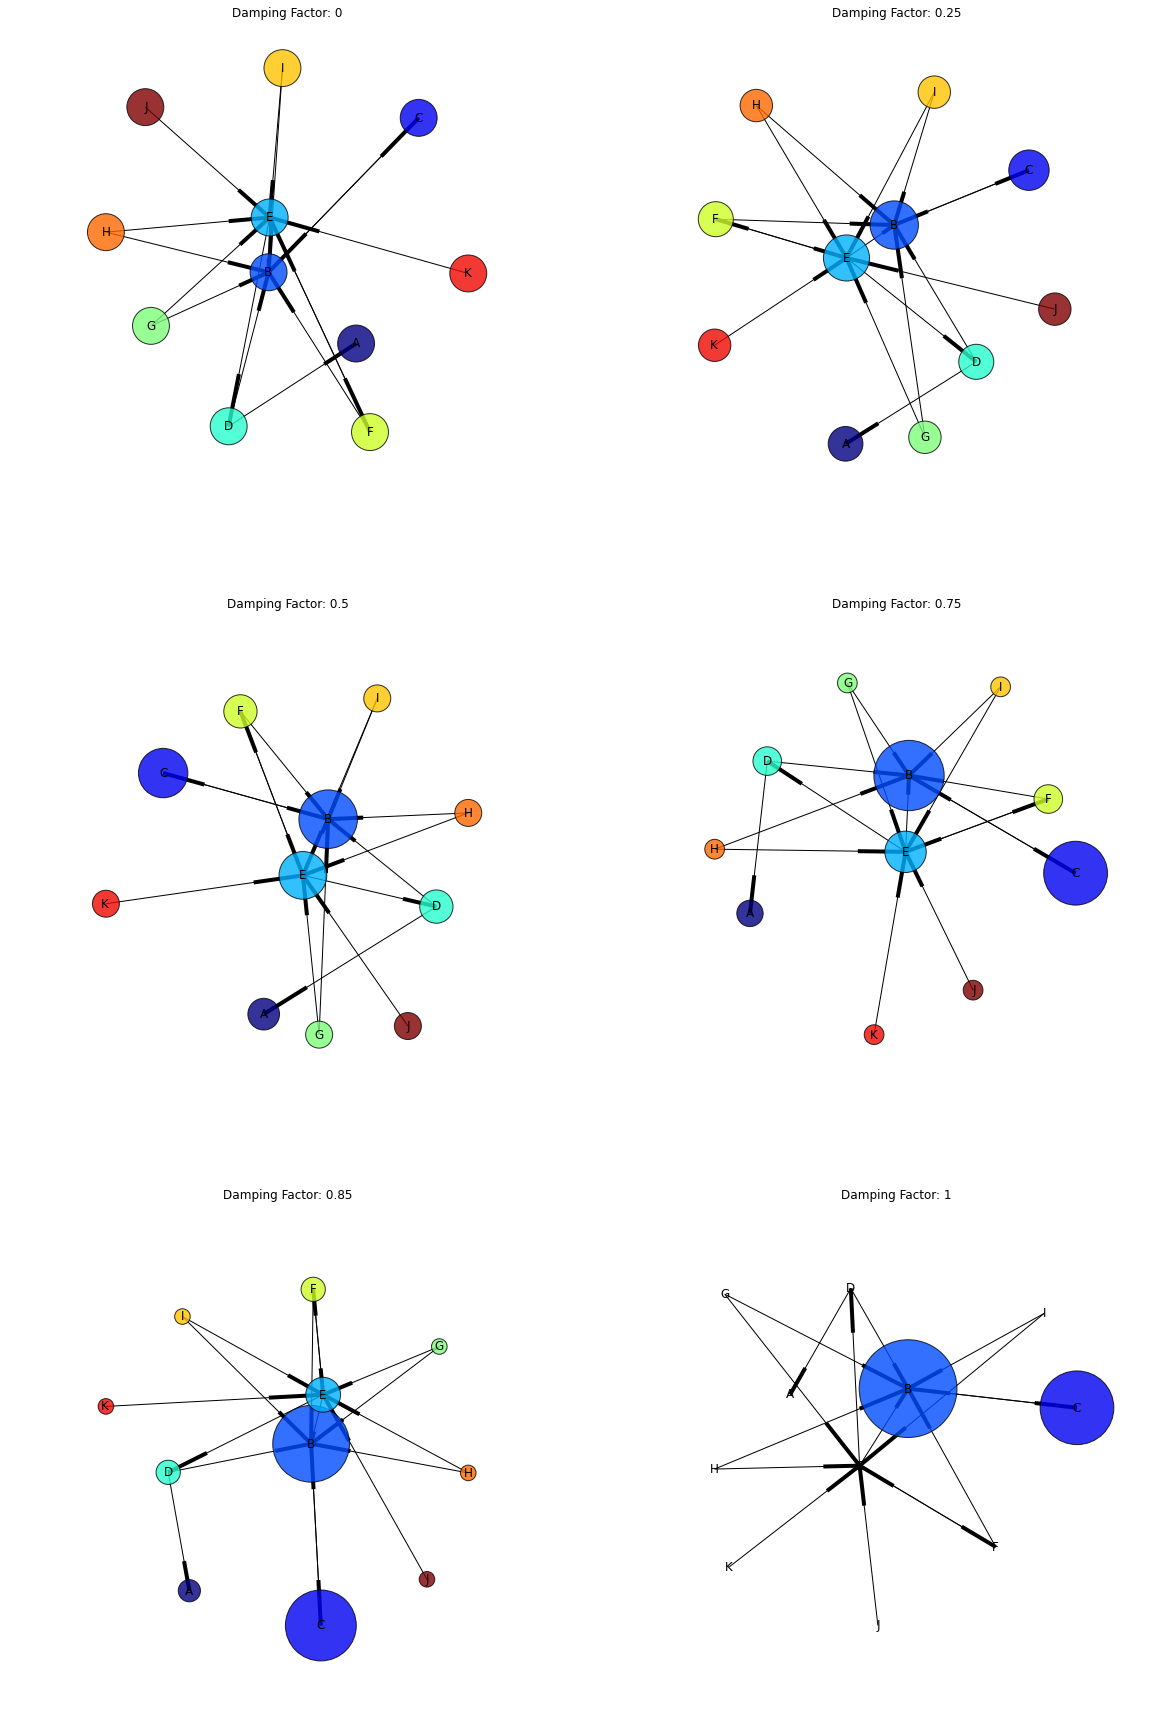

In [63]:
# Make bunch of network plots
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import os

plt.figure(figsize=(20, 30))

def parseGraph(input_file):
    DG=nx.DiGraph()
    for line in open(input_file, 'r'):
        lineArr = line.strip().split('\t')
        nodeId = lineArr[0].replace('"', '')
        nodeData = eval(lineArr[1])
        outlinks = nodeData[0]
        rankVal = nodeData[1]  
        DG.add_node(nodeId, rank=rankVal)
        for outNode in outlinks:
            DG.add_edge(nodeId, outNode.replace('"', ''))
    return DG
            
d_factors = [0,0.25,0.5,0.75, 0.85, 1]
#input_files = [os.path.join('VaryingDampingFactors', str(d), 'iterfinal', 'part-00000')  for d in d_factors]
for j,df in enumerate(d_factors):
    plt.subplot(3, 2, j+1)
    DG = parseGraph(os.path.join('VaryingDampingFactors', str(df), 'iterfinal', 'part-00000'))
    
    try:
        pos=nx.graphviz_layout(DG)
    except:
        pos=nx.spring_layout(DG,iterations=20)
        
    nx.draw_networkx_nodes(DG, pos, node_size=[d[1]['rank']*15000 for d in DG.nodes(data=True)],
                           cmap=plt.get_cmap('jet'), node_color=[i for i,d in enumerate(DG.nodes())],
                           alpha=0.8)
    nx.draw_networkx_edges(DG, pos)
    nx.draw_networkx_labels(DG,pos,fontsize=14)
    plt.axis('off')
    plt.title("Damping Factor: %s"%df)
    
plt.show()

# HW 9.3: Applying PageRank to the Wikipedia hyperlinks network

Run your PageRank implementation on the Wikipedia dataset for 5 iterations,
and display the top 100 ranked nodes (with alpha = 0.85).

Run your PageRank implementation on the Wikipedia dataset for 10 iterations,
and display the top 100 ranked nodes (with teleportation factor of 0.15). 
Have the top 100 ranked pages changed? Comment on your findings.

Plot the pagerank values for the top 100 pages resulting from the 5 iterations run. Then plot the pagerank values for the same 100 pages that resulted from the 10 iterations run.

In [1]:
# configuration for running MRJob on EMR
import os

aws_id = os.environ['AWSAccessKeyId']
aws_key = os.environ['AWSSecretKey']

writer = open('mrjob_emr.conf', 'w')
writer.write(
"""runners:
  emr:
    aws_access_key_id: %s
    aws_region: us-east-1
    ec2_instance_type: m1.medium
    ec2_master_instance_type: m1.medium
    num_ec2_instances: 5
    aws_secret_access_key: %s"""%(aws_id, aws_key)
)
writer.close()

In [2]:
# 1-5 iterations

%load_ext autoreload
%autoreload 2
from pageRank import PageRank

output_dir = 's3://lin.berkeley.mids/w261/wikiPageRank/iter'
input_file = 's3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt'

# first iteration, collect normalization factors
mr_job = PageRank(args=[input_file, '-r', 'emr', '-c', 'mrjob_emr.conf', 
                        '--pool-emr-job-flows', '--no-output', 
                        '--output-dir='+output_dir+'1'])
with mr_job.make_runner() as runner: 
    runner.run()
    norm_factor = runner.counters()[0]['prank']['prod_norm_factor']
    
# second iteration, normalize initialization values, and collect total nodes
mr_job = PageRank(args=['-r', 'emr', '-c', 'mrjob_emr.conf', '--pool-emr-job-flows', 
                        output_dir+'1', '--no-output', '--output-dir='+output_dir+'2', 
                        '--prob-norm-factor='+str(norm_factor)])
with mr_job.make_runner() as runner: 
    runner.run()
    total_nodes = runner.counters()[0]['prank']['total_nodes']
    loss_mass = 0.0
    if 'prank' in runner.counters()[0] and 'loss_mass' in runner.counters()[0]['prank']:
        loss_mass = 1.0*runner.counters()[0]['prank']['loss_mass']/(10**mr_job.options.counter_precision)

# iter until no changes or max iter reached
iter_num = 2
max_iter = 5
while(1):
    iter_num += 1
    
    print "total nodes: %s"%total_nodes
    print "last iter loss mass: %s"%loss_mass
    
    if iter_num == max_iter or ('prank' in runner.counters()[0] and 'chg_over_thold' not in runner.counters()[0]['prank']):
        final_iter = True
    else:
        final_iter = False
    
    if not final_iter:
        mr_job = PageRank(args=['-r', 'emr', '-c', 'mrjob_emr.conf', '--pool-emr-job-flows', 
                                output_dir+str(iter_num-1), '--no-output', 
                                '--output-dir='+output_dir+str(iter_num), '--total-nodes='+str(total_nodes), 
                                '--loss-mass='+str(loss_mass)])
    else:
        mr_job = PageRank(args=['-r', 'emr', '-c', 'mrjob_emr.conf', '--pool-emr-job-flows', 
                                output_dir+str(iter_num-1), '--no-output', 
                                '--output-dir='+output_dir+str(iter_num)+'final', 
                                '--total-nodes='+str(total_nodes), '--loss-mass='+str(loss_mass), 
                                '--is-final-iter=1'])
    with mr_job.make_runner() as runner: 
        runner.run()
        loss_mass = 0.0
        if 'prank' in runner.counters()[0] and 'loss_mass' in runner.counters()[0]['prank']:
            loss_mass = 1.0*runner.counters()[0]['prank']['loss_mass']/(10**mr_job.options.counter_precision)
    
    if final_iter:
        break

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
total nodes: 15192277


last iter loss mass: 0.100444
total nodes: 15192277


last iter loss mass: 0.01156
total nodes: 15192277


last iter loss mass: 0.00068


#### Grab top 100 ranked nodes

In [2]:
# configuration for running MRJob on EMR
import os

aws_id = os.environ['AWSAccessKeyId']
aws_key = os.environ['AWSSecretKey']

writer = open('mrjob_emr.conf', 'w')
writer.write(
"""runners:
  emr:
    aws_access_key_id: %s
    aws_region: us-east-1
    ec2_instance_type: m1.medium
    ec2_master_instance_type: m1.medium
    num_ec2_instances: 2
    aws_secret_access_key: %s"""%(aws_id, aws_key)
)
writer.close()

In [ ]:
# Top 100 nodes from the 5 iteratino run
!python topNPageRanks.py -r emr -c mrjob_emr.conf s3://lin.berkeley.mids/w261/wikiPageRank/iter5final --top-n=100

# HW 9.4: Topic-specific PageRank implementation using MRJob

Modify your PageRank implementation to produce a topic specific PageRank implementation,
as described in:

http://www-cs-students.stanford.edu/~taherh/papers/topic-sensitive-pagerank.pdf

Note in this article that there is a special caveat to ensure that the transition matrix is 
irreducible.  This caveat lies in footnote 3 on page 3:

	A minor caveat: to ensure that M is irreducible when p
	contains any 0 entries, nodes not reachable from nonzero
	nodes in p should be removed. In practice this is not problematic.

and must be adhered to for convergence to be guaranteed.

Run topic specific PageRank on the following randomly generated network of 100 nodes:

s3://ucb-mids-mls-networks/randNet.txt (also available on Dropbox)

which are organized into ten topics, as described in the file:

s3://ucb-mids-mls-networks/randNet_topics.txt  (also available on Dropbox)

Since there are 10 topics, your result should be 11 PageRank vectors
(one for the vanilla PageRank implementation in 9.1, and one for each topic
with the topic specific implementation). Print out the top ten ranking nodes 
and their topics for each of the 11 versions, and comment on your result. 
Assume a teleportation factor of 0.15 in all your analyses.

One final and important comment here:  please consider the 
requirements for irreducibility with topic-specific PageRank.
In particular, the literature ensures irreducibility by requiring that
nodes not reachable from in-topic nodes be removed from the network.

This is not a small task, especially as it it must be performed
separately for each of the (10) topics.

So, instead of using this method for irreducibility, 
please comment on why the literature's method is difficult to implement,
and what what extra computation it will require.
Then for your code, please use the alternative, 
non-uniform damping vector:

vji = beta*(1/|Tj|); if node i lies in topic Tj

vji = (1-beta)*(1/(N - |Tj|)); if node i lies outside of topic Tj

for beta in (0,1) close to 1. 

With this approach, you will not have to delete any nodes.
If beta > 0.5, PageRank is topic-sensitive, 
and if beta < 0.5, the PageRank is anti-topic-sensitive. 
For any value of beta irreducibility should hold,
so please try beta=0.99, and perhaps some other values locally,
on the smaller networks.


#### MRJob code for topic-specific PageRank

In [10]:
%%writefile topicSpecificPageRank.py
from mrjob.job import MRJob
from mrjob.step import MRStep

class PageRank(MRJob):
       
    def configure_options(self):
        super(PageRank, self).configure_options()

        self.add_passthrough_option(
            '--prob-norm-factor', dest='prob_norm_factor', default=0.0, type='float',
            help='normalization factor for node weights')

        self.add_passthrough_option(
            '--damping-factor', dest='damping_factor', default=0.85,
            type='float',
            help='probability a web surfer will continue clicking on links')
        
        self.add_passthrough_option(
            '--total-nodes', dest='total_nodes', default=-1,
            type='int',
            help='total number of nodes in the graph')
        
        self.add_passthrough_option(
            '--loss-mass', dest='loss_mass', default=0.0,
            type='float',
            help='loss mass that needs to be redistributed')
        
        self.add_passthrough_option(
            '--counter-precision', dest='counter_precision', default=6,
            type='int',
            help='number of decimal points to preserve when using counter to store floats')
        
        self.add_passthrough_option(
            '--prank-chg-thold', dest='prank_chg_thold', default=0.001,
            type='float',
            help='threshold for change in PageRank value to continue iteration')
        
        self.add_passthrough_option(
            '--is-final-iter', dest='is_final_iter', default=0,
            type='int',
            help='1 indicates final iteration which needs to apply just the mapper.')
        
        self.add_passthrough_option(
            '--topic-beta', dest='topic_beta', default=0.99,
            type='float',
            help='weighting factor for topic teleportation prob.')
        
        self.add_passthrough_option(
            '--topic-id', dest='topic_id', default="",
            help='topic selection of topic-specific PageRank')
        
        self.add_passthrough_option(
            '--topic-file', dest='topic_file', default="",
            help='tab-seperated file with nodeId[\t]topicId format')
        
    def loadTopicFile(self):
        self.topic_mapper = {}
        if self.options.topic_file != '':
            for line in open(self.options.topic_file, 'r'):
                nodeId, topicId = line.strip().split('\t')
                if topicId in self.topic_mapper:
                    self.topic_mapper[topicId].add(nodeId)
                else:
                    self.topic_mapper[topicId] = set([nodeId])
                    
    def mapper_init(self):
        if self.options.topic_id != '':
            self.loadTopicFile()
        else:
            self.topic_mapper = None
            
    def lookupNodeTopicWeight(self, nodeId, topicId):
        if nodeId != '' and topicId != '' and self.topic_mapper != None and topicId in self.topic_mapper:
            topicSet = self.topic_mapper[topicId]
            if nodeId in topicSet:
                return self.options.topic_beta*(1.0/len(topicSet))
            else:
                return (1.0-self.options.topic_beta)*(1.0/(self.options.total_nodes-len(topicSet)))
        else:
            return 1.0/self.options.total_nodes

    def sendScores(self, _, line):
        # Mapper, send score to each outline
        
        if self.options.total_nodes == -1:
            # accoumate total node numbers
            self.increment_counter('prank', 'total_nodes', 1)
        
        lineArr = line.strip().split('\t')
        
        if '[' not in line: # original input
            # first iteration, don't have total node numbers yet.
            # initialize pageRank to 1.0, and will have to normalize later
            node_weight = 1.0
            node_id = lineArr[0]
            outlinks = eval(lineArr[1])
            self.increment_counter('prank', 'prod_norm_factor', 1)
        else:
            node_id = lineArr[0].replace('"', '')
            payload = eval(lineArr[1])
            outlinks = payload[0]
            node_weight = payload[1]
            if self.options.prob_norm_factor > 0: # need to re-normalize weights so they sum up to 1
                node_weight = node_weight / self.options.prob_norm_factor
                
            if self.options.total_nodes != -1:
                # accounts for teleportation and dangling nodes
                node_weight = (1-self.options.damping_factor)*self.lookupNodeTopicWeight(node_id,self.options.topic_id) + self.options.damping_factor*(self.options.loss_mass/self.options.total_nodes + node_weight)
        
        if self.options.is_final_iter == 1:
            yield node_id, (outlinks, round(node_weight, 4))
        else:
            yield node_id, ('node', outlinks, node_weight) # original node info
            if len(outlinks) == 0:
                # dangling nodes, increment loss mass counter
                self.increment_counter('prank', 'loss_mass', int(node_weight*(10**self.options.counter_precision)))
            else:
                for out_node in outlinks:
                    yield out_node, ('score', 1.0*node_weight/len(outlinks), self.options.counter_precision) # new score
                    
    def sendScoreCombinder(self, nodeId, payload):
        total_new_score = 0.0
        for data in payload:
            if data[0] == 'node':
                yield nodeId, data
            else:
                total_new_score += data[1]
        if total_new_score > 0:
            yield nodeId, ('score', total_new_score)
                
    def receive_scores(self, nodeId, payload):
        prev_score = 0.0
        outlinks = {}
        total_new_score = 0.0
        
        for data in payload:
            if data[0] == 'node':
                outlinks = data[1]
                prev_score = data[2]
            else:
                total_new_score += data[1]
                      
        if abs(total_new_score-prev_score) > self.options.prank_chg_thold:
            self.increment_counter('prank', 'chg_over_thold', 1)
        
        yield nodeId, (outlinks, round(total_new_score, 4))
        
    def steps(self):
        if self.options.is_final_iter == 1:
            return ([MRStep(mapper_init=self.mapper_init, mapper=self.sendScores)])
        else:
            return ([MRStep(mapper_init=self.mapper_init, mapper=self.sendScores, reducer=self.receive_scores)])

Overwriting topicSpecificPageRank.py


#### Driver code for topic-specific PageRank

In [8]:
%%writefile topicSpecificPRDriver.py
from topicSpecificPageRank import PageRank
import os
import sys

args = dict(map(lambda x: x.lstrip('-').split('='), sys.argv[1:]))

# default settings
output_dir = 'TopicSpecificPageRanks'
input_file = 'randNet.txt'
topic_file = 'randNet_topics.txt'
topicId = ''
max_iter = 20

if 'output-dir' in args:
    output_dir = args['output-dir']
if 'input-file' in args:
    input_file = args['input-file']
if 'topic-file' in args:
    topic_file = args['topic-file']
if 'topic-id' in args:
    topicId = args['topic-id']
if 'max-iter' in args:
    max_iter = int(args['max-iter'])

# first iteration, collect normalization factors
mr_job = PageRank(args=[input_file, '--no-output', '--output-dir='+os.path.join(output_dir,'iter1')])
with mr_job.make_runner() as runner: 
    runner.run()
    norm_factor = runner.counters()[0]['prank']['prod_norm_factor']
    
# second iteration, normalize initialization values, and collect total nodes
mr_job = PageRank(args=[os.path.join(output_dir,'iter1'), '--no-output', '--output-dir='+os.path.join(output_dir,'iter2')
                        , '--prob-norm-factor='+str(norm_factor)])
with mr_job.make_runner() as runner: 
    runner.run()
    total_nodes = runner.counters()[0]['prank']['total_nodes']
    print "total nodes: %s"%total_nodes
    loss_mass = 0.0
    if 'prank' in runner.counters()[0] and 'loss_mass' in runner.counters()[0]['prank']:
        loss_mass = 1.0*runner.counters()[0]['prank']['loss_mass']/(10**mr_job.options.counter_precision)

# iter until no changes or max iter reached
iter_num = 2
while(1):
    iter_num += 1
    
    if iter_num == max_iter or ('prank' in runner.counters()[0] and 'chg_over_thold' not in runner.counters()[0]['prank']):
        final_iter = True
    else:
        final_iter = False
    
    if topicId == '' or topic_file == '':
        if not final_iter:
            mr_job = PageRank(args=[os.path.join(output_dir,'iter'+str(iter_num-1)), '--no-output', 
                    '--output-dir='+os.path.join(output_dir,'iter'+str(iter_num)), 
                    '--total-nodes='+str(total_nodes), '--loss-mass='+str(loss_mass)])
        else:
            mr_job = PageRank(args=[os.path.join(output_dir,'iter'+str(iter_num-1)), '--no-output', 
                    '--output-dir='+os.path.join(output_dir,'final'), 
                    '--total-nodes='+str(total_nodes), '--loss-mass='+str(loss_mass), '--is-final-iter=1'])
    else:
        if not final_iter:
            mr_job = PageRank(args=[os.path.join(output_dir,'iter'+str(iter_num-1)), '--no-output', 
                    '--output-dir='+os.path.join(output_dir,'iter'+str(iter_num)), 
                    '--total-nodes='+str(total_nodes), '--loss-mass='+str(loss_mass),
                    '--file', topic_file, '--topic-file='+topic_file, '--topic-id='+topicId])
        else:
            mr_job = PageRank(args=[os.path.join(output_dir,'iter'+str(iter_num-1)), '--no-output', 
                    '--output-dir='+os.path.join(output_dir,'final'), 
                    '--total-nodes='+str(total_nodes), '--loss-mass='+str(loss_mass), '--is-final-iter=1',
                    '--file', topic_file, '--topic-file='+topic_file, '--topic-id='+topicId])
        
    with mr_job.make_runner() as runner: 
        runner.run()
        loss_mass = 0.0
        if not final_iter and 'prank' in runner.counters()[0] and 'loss_mass' in runner.counters()[0]['prank']:
            loss_mass = 1.0*runner.counters()[0]['prank']['loss_mass']/(10**mr_job.options.counter_precision)
    
    if final_iter:
        break

Overwriting topicSpecificPRDriver.py


In [11]:
# first run, no topic weightage
!python topicSpecificPRDriver.py --output-dir=TopicSpecificPageRanks\\no_topic

total nodes: 100


No handlers could be found for logger "mrjob.runner"


In [22]:
# topic 1
!python topicSpecificPRDriver.py --output-dir=TopicSpecificPageRanks\\topic1 --topic-id=1

total nodes: 100


No handlers could be found for logger "mrjob.runner"


In [23]:
# topic 2
!python topicSpecificPRDriver.py --output-dir=TopicSpecificPageRanks\\topic2 --topic-id=2

total nodes: 100


No handlers could be found for logger "mrjob.runner"


In [24]:
# topic 3
!python topicSpecificPRDriver.py --output-dir=TopicSpecificPageRanks\\topic3 --topic-id=3

total nodes: 100


No handlers could be found for logger "mrjob.runner"


In [25]:
# topic 4
!python topicSpecificPRDriver.py --output-dir=TopicSpecificPageRanks\\topic4 --topic-id=4

total nodes: 100


No handlers could be found for logger "mrjob.runner"


In [26]:
# topic 5
!python topicSpecificPRDriver.py --output-dir=TopicSpecificPageRanks\\topic5 --topic-id=5

total nodes: 100


No handlers could be found for logger "mrjob.runner"


In [27]:
# topic 6
!python topicSpecificPRDriver.py --output-dir=TopicSpecificPageRanks\\topic6 --topic-id=6

total nodes: 100


No handlers could be found for logger "mrjob.runner"


In [28]:
# topic 7
!python topicSpecificPRDriver.py --output-dir=TopicSpecificPageRanks\\topic7 --topic-id=7

total nodes: 100


No handlers could be found for logger "mrjob.runner"


In [29]:
# topic 8
!python topicSpecificPRDriver.py --output-dir=TopicSpecificPageRanks\\topic8 --topic-id=8

total nodes: 100


No handlers could be found for logger "mrjob.runner"


In [30]:
# topic 9
!python topicSpecificPRDriver.py --output-dir=TopicSpecificPageRanks\\topic9 --topic-id=9

total nodes: 100


No handlers could be found for logger "mrjob.runner"


In [31]:
# topic 10
!python topicSpecificPRDriver.py --output-dir=TopicSpecificPageRanks\\topic10 --topic-id=10

total nodes: 100


No handlers could be found for logger "mrjob.runner"


#### Print out top 10 ranked nodes from each result

In [36]:
%%writefile topic_specific_topN.py

from mrjob.job import MRJob

class topNPageRanks(MRJob):
    
    def configure_options(self):
        super(topNPageRanks, self).configure_options()

        self.add_passthrough_option(
            '--top-n', dest='top_n', default=10, type='int',
            help='select top N page ranks')
    
    def mapper(self, _, line):
        lineArr = line.strip().split('\t')
        nodeId = lineArr[0].replace('"', '')
        rank_val = eval(lineArr[1])[1]
        yield None, (rank_val, nodeId)
        
    def combiner(self, _, ranked_nodes):
        top_n_nodes = []
        for node in ranked_nodes:
            if len(top_n_nodes) < self.options.top_n:
                top_n_nodes.append(node)
                top_n_nodes = sorted(top_n_nodes, reverse=True)
            elif node[0] > top_n_nodes[self.options.top_n-1][0]:
                top_n_nodes.append(node)
                top_n_nodes = sorted(top_n_nodes, reverse=True)[:self.options.top_n]
        for node in top_n_nodes:
            yield None, node
            
    def reducer_init(self):
        self.topic_mapper = {}
        for line in open('randNet_topics.txt', 'r'):
            nodeId, topicId = line.strip().split('\t')
            self.topic_mapper[nodeId] = topicId
        
    def reducer(self, _, ranked_nodes):
        top_n_nodes = []
        for node in ranked_nodes:
            if len(top_n_nodes) < self.options.top_n:
                top_n_nodes.append(node)
                top_n_nodes = sorted(top_n_nodes, reverse=True)
            elif node[0] > top_n_nodes[self.options.top_n-1][0]:
                top_n_nodes.append(node)
                top_n_nodes = sorted(top_n_nodes, reverse=True)[:self.options.top_n]
        for node in top_n_nodes:
            yield node[1]+' [topic: '+self.topic_mapper[node[1]]+']', node[0]

if __name__ == '__main__':
    topNPageRanks.run()

Overwriting topic_specific_topN.py


In [37]:
# No topic weightage
!python topic_specific_topN.py TopicSpecificPageRanks\\no_topic\\final --file randNet_topics.txt

"15 [topic: 3]"	0.0164
"74 [topic: 10]"	0.016
"63 [topic: 4]"	0.0158
"100 [topic: 8]"	0.0154
"85 [topic: 7]"	0.0152
"9 [topic: 2]"	0.015
"58 [topic: 2]"	0.0148
"71 [topic: 2]"	0.0145
"61 [topic: 8]"	0.0144
"52 [topic: 1]"	0.0143


no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating tmp directory c:\temp\topic_specific_topN.kuanlin.20160315.004503.988000

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

writing to c:\temp\topic_specific_topN.kuanlin.20160315.004503.988000\step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to c:\temp\topic_specific_topN.kuanlin.20160315.004503.988000\step-0-mapper-sorted
> sort 'c:\temp\topic_specific_topN.kuanlin.20160315.004503.988000\step-0-mapper_part-00000'
writing to c:\temp\topic_specific_topN.kuanlin.20160315.004503.988000\step-0-reducer_part-00000
Counters from step 1:
  (no counters found)
Moving c:\temp\topic_specific_topN.kuanlin.20160315.004503.988000\step-0-reducer_part-00000 -> c:\temp\

In [38]:
# topic 1
!python topic_specific_topN.py TopicSpecificPageRanks\\topic1\\final --file randNet_topics.txt

"77 [topic: 1]"	0.0206
"32 [topic: 1]"	0.0206
"52 [topic: 1]"	0.0198
"92 [topic: 1]"	0.0195
"10 [topic: 1]"	0.0186
"27 [topic: 1]"	0.0185
"85 [topic: 7]"	0.0179
"98 [topic: 1]"	0.0177
"46 [topic: 1]"	0.0175
"74 [topic: 10]"	0.016


no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating tmp directory c:\temp\topic_specific_topN.kuanlin.20160315.004535.027000

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

writing to c:\temp\topic_specific_topN.kuanlin.20160315.004535.027000\step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to c:\temp\topic_specific_topN.kuanlin.20160315.004535.027000\step-0-mapper-sorted
> sort 'c:\temp\topic_specific_topN.kuanlin.20160315.004535.027000\step-0-mapper_part-00000'
writing to c:\temp\topic_specific_topN.kuanlin.20160315.004535.027000\step-0-reducer_part-00000
Counters from step 1:
  (no counters found)
Moving c:\temp\topic_specific_topN.kuanlin.20160315.004535.027000\step-0-reducer_part-00000 -> c:\temp\

In [39]:
# topic 2
!python topic_specific_topN.py TopicSpecificPageRanks\\topic2\\final --file randNet_topics.txt

"58 [topic: 2]"	0.0309
"71 [topic: 2]"	0.0297
"9 [topic: 2]"	0.0293
"73 [topic: 2]"	0.0289
"12 [topic: 2]"	0.0269
"59 [topic: 2]"	0.0258
"75 [topic: 2]"	0.0249
"82 [topic: 2]"	0.0229
"52 [topic: 1]"	0.0163
"17 [topic: 10]"	0.0151


no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating tmp directory c:\temp\topic_specific_topN.kuanlin.20160315.004554.412000

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

writing to c:\temp\topic_specific_topN.kuanlin.20160315.004554.412000\step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to c:\temp\topic_specific_topN.kuanlin.20160315.004554.412000\step-0-mapper-sorted
> sort 'c:\temp\topic_specific_topN.kuanlin.20160315.004554.412000\step-0-mapper_part-00000'
writing to c:\temp\topic_specific_topN.kuanlin.20160315.004554.412000\step-0-reducer_part-00000
Counters from step 1:
  (no counters found)
Moving c:\temp\topic_specific_topN.kuanlin.20160315.004554.412000\step-0-reducer_part-00000 -> c:\temp\

In [40]:
# topic 3
!python topic_specific_topN.py TopicSpecificPageRanks\\topic3\\final --file randNet_topics.txt

"15 [topic: 3]"	0.0315
"70 [topic: 3]"	0.027
"86 [topic: 3]"	0.0265
"91 [topic: 3]"	0.0245
"66 [topic: 3]"	0.0241
"2 [topic: 3]"	0.0237
"31 [topic: 3]"	0.0228
"40 [topic: 3]"	0.0222
"20 [topic: 3]"	0.0197
"74 [topic: 10]"	0.0159


no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating tmp directory c:\temp\topic_specific_topN.kuanlin.20160315.004604.216000

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

writing to c:\temp\topic_specific_topN.kuanlin.20160315.004604.216000\step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to c:\temp\topic_specific_topN.kuanlin.20160315.004604.216000\step-0-mapper-sorted
> sort 'c:\temp\topic_specific_topN.kuanlin.20160315.004604.216000\step-0-mapper_part-00000'
writing to c:\temp\topic_specific_topN.kuanlin.20160315.004604.216000\step-0-reducer_part-00000
Counters from step 1:
  (no counters found)
Moving c:\temp\topic_specific_topN.kuanlin.20160315.004604.216000\step-0-reducer_part-00000 -> c:\temp\

In [41]:
# topic 4
!python topic_specific_topN.py TopicSpecificPageRanks\\topic4\\final --file randNet_topics.txt

"63 [topic: 4]"	0.0262
"83 [topic: 4]"	0.0218
"65 [topic: 4]"	0.0206
"78 [topic: 4]"	0.0202
"41 [topic: 4]"	0.0199
"84 [topic: 4]"	0.0195
"79 [topic: 4]"	0.0184
"38 [topic: 4]"	0.0175
"15 [topic: 3]"	0.0168
"72 [topic: 4]"	0.0167


no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating tmp directory c:\temp\topic_specific_topN.kuanlin.20160315.004613.098000

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

writing to c:\temp\topic_specific_topN.kuanlin.20160315.004613.098000\step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to c:\temp\topic_specific_topN.kuanlin.20160315.004613.098000\step-0-mapper-sorted
> sort 'c:\temp\topic_specific_topN.kuanlin.20160315.004613.098000\step-0-mapper_part-00000'
writing to c:\temp\topic_specific_topN.kuanlin.20160315.004613.098000\step-0-reducer_part-00000
Counters from step 1:
  (no counters found)
Moving c:\temp\topic_specific_topN.kuanlin.20160315.004613.098000\step-0-reducer_part-00000 -> c:\temp\

In [42]:
# topic 5
!python topic_specific_topN.py TopicSpecificPageRanks\\topic5\\final --file randNet_topics.txt

"99 [topic: 5]"	0.029
"90 [topic: 5]"	0.0284
"88 [topic: 5]"	0.0272
"51 [topic: 5]"	0.0269
"45 [topic: 5]"	0.0256
"5 [topic: 5]"	0.0239
"34 [topic: 5]"	0.0239
"4 [topic: 5]"	0.0234
"80 [topic: 5]"	0.0229
"100 [topic: 8]"	0.0168


no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating tmp directory c:\temp\topic_specific_topN.kuanlin.20160315.004624.738000

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

writing to c:\temp\topic_specific_topN.kuanlin.20160315.004624.738000\step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to c:\temp\topic_specific_topN.kuanlin.20160315.004624.738000\step-0-mapper-sorted
> sort 'c:\temp\topic_specific_topN.kuanlin.20160315.004624.738000\step-0-mapper_part-00000'
writing to c:\temp\topic_specific_topN.kuanlin.20160315.004624.738000\step-0-reducer_part-00000
Counters from step 1:
  (no counters found)
Moving c:\temp\topic_specific_topN.kuanlin.20160315.004624.738000\step-0-reducer_part-00000 -> c:\temp\

In [43]:
# topic 6
!python topic_specific_topN.py TopicSpecificPageRanks\\topic6\\final --file randNet_topics.txt

"13 [topic: 6]"	0.0346
"56 [topic: 6]"	0.0328
"37 [topic: 6]"	0.0318
"11 [topic: 6]"	0.0314
"69 [topic: 6]"	0.0301
"23 [topic: 6]"	0.0283
"15 [topic: 3]"	0.0173
"85 [topic: 7]"	0.017
"52 [topic: 1]"	0.0166
"74 [topic: 10]"	0.0155


no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating tmp directory c:\temp\topic_specific_topN.kuanlin.20160315.004645.243000

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

writing to c:\temp\topic_specific_topN.kuanlin.20160315.004645.243000\step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to c:\temp\topic_specific_topN.kuanlin.20160315.004645.243000\step-0-mapper-sorted
> sort 'c:\temp\topic_specific_topN.kuanlin.20160315.004645.243000\step-0-mapper_part-00000'
writing to c:\temp\topic_specific_topN.kuanlin.20160315.004645.243000\step-0-reducer_part-00000
Counters from step 1:
  (no counters found)
Moving c:\temp\topic_specific_topN.kuanlin.20160315.004645.243000\step-0-reducer_part-00000 -> c:\temp\

In [44]:
# topic 7
!python topic_specific_topN.py TopicSpecificPageRanks\\topic7\\final --file randNet_topics.txt

"85 [topic: 7]"	0.0268
"25 [topic: 7]"	0.0266
"53 [topic: 7]"	0.0248
"28 [topic: 7]"	0.0248
"35 [topic: 7]"	0.0242
"97 [topic: 7]"	0.0234
"47 [topic: 7]"	0.0228
"55 [topic: 7]"	0.0226
"30 [topic: 7]"	0.0222
"50 [topic: 7]"	0.0201


no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating tmp directory c:\temp\topic_specific_topN.kuanlin.20160315.004653.422000

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

writing to c:\temp\topic_specific_topN.kuanlin.20160315.004653.422000\step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to c:\temp\topic_specific_topN.kuanlin.20160315.004653.422000\step-0-mapper-sorted
> sort 'c:\temp\topic_specific_topN.kuanlin.20160315.004653.422000\step-0-mapper_part-00000'
writing to c:\temp\topic_specific_topN.kuanlin.20160315.004653.422000\step-0-reducer_part-00000
Counters from step 1:
  (no counters found)
Moving c:\temp\topic_specific_topN.kuanlin.20160315.004653.422000\step-0-reducer_part-00000 -> c:\temp\

In [45]:
# topic 8
!python topic_specific_topN.py TopicSpecificPageRanks\\topic8\\final --file randNet_topics.txt

"100 [topic: 8]"	0.0329
"61 [topic: 8]"	0.0279
"8 [topic: 8]"	0.0272
"39 [topic: 8]"	0.0272
"87 [topic: 8]"	0.0253
"62 [topic: 8]"	0.0253
"6 [topic: 8]"	0.0236
"54 [topic: 8]"	0.0229
"18 [topic: 8]"	0.0207
"9 [topic: 2]"	0.0154


no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating tmp directory c:\temp\topic_specific_topN.kuanlin.20160315.004703.556000

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

writing to c:\temp\topic_specific_topN.kuanlin.20160315.004703.556000\step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to c:\temp\topic_specific_topN.kuanlin.20160315.004703.556000\step-0-mapper-sorted
> sort 'c:\temp\topic_specific_topN.kuanlin.20160315.004703.556000\step-0-mapper_part-00000'
writing to c:\temp\topic_specific_topN.kuanlin.20160315.004703.556000\step-0-reducer_part-00000
Counters from step 1:
  (no counters found)
Moving c:\temp\topic_specific_topN.kuanlin.20160315.004703.556000\step-0-reducer_part-00000 -> c:\temp\

In [46]:
# topic 9
!python topic_specific_topN.py TopicSpecificPageRanks\\topic9\\final --file randNet_topics.txt

"94 [topic: 9]"	0.0302
"14 [topic: 9]"	0.0295
"42 [topic: 9]"	0.0292
"21 [topic: 9]"	0.0284
"57 [topic: 9]"	0.0274
"96 [topic: 9]"	0.0262
"24 [topic: 9]"	0.0258
"63 [topic: 4]"	0.0172
"61 [topic: 8]"	0.0163
"74 [topic: 10]"	0.0143


no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating tmp directory c:\temp\topic_specific_topN.kuanlin.20160315.004712.382000

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

writing to c:\temp\topic_specific_topN.kuanlin.20160315.004712.382000\step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to c:\temp\topic_specific_topN.kuanlin.20160315.004712.382000\step-0-mapper-sorted
> sort 'c:\temp\topic_specific_topN.kuanlin.20160315.004712.382000\step-0-mapper_part-00000'
writing to c:\temp\topic_specific_topN.kuanlin.20160315.004712.382000\step-0-reducer_part-00000
Counters from step 1:
  (no counters found)
Moving c:\temp\topic_specific_topN.kuanlin.20160315.004712.382000\step-0-reducer_part-00000 -> c:\temp\

In [47]:
# topic 10
!python topic_specific_topN.py TopicSpecificPageRanks\\topic10\\final --file randNet_topics.txt

"74 [topic: 10]"	0.0263
"49 [topic: 10]"	0.0236
"17 [topic: 10]"	0.0236
"95 [topic: 10]"	0.0206
"7 [topic: 10]"	0.0199
"43 [topic: 10]"	0.0193
"68 [topic: 10]"	0.0191
"48 [topic: 10]"	0.019
"1 [topic: 10]"	0.019
"3 [topic: 10]"	0.0187


no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating tmp directory c:\temp\topic_specific_topN.kuanlin.20160315.004722.244000

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

writing to c:\temp\topic_specific_topN.kuanlin.20160315.004722.244000\step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to c:\temp\topic_specific_topN.kuanlin.20160315.004722.244000\step-0-mapper-sorted
> sort 'c:\temp\topic_specific_topN.kuanlin.20160315.004722.244000\step-0-mapper_part-00000'
writing to c:\temp\topic_specific_topN.kuanlin.20160315.004722.244000\step-0-reducer_part-00000
Counters from step 1:
  (no counters found)
Moving c:\temp\topic_specific_topN.kuanlin.20160315.004722.244000\step-0-reducer_part-00000 -> c:\temp\

#### General Discussion

The topic-specific PageRank works very well, resulting preferentially higher rankings for nodes belonging to the specific topic.

To implement the exact logic in the paper (removing non-reachable nodes per topic) requires one additional mapper step for each topic to pre-screen feasible nodes, and write the intermediate result out to storage since it would be impossible to store the real-life networks in memory.  This would obviously more inefficient and more costly then what we did in the code above.